# Generate Audio for Behavior Task

## Initial setup

In [1]:
import wave, struct, math
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt

In [2]:
output_dir = '/home/james/Desktop/sounds/'

## Sine wave

In [3]:
filename = 'tone.wav'

# Audio settings
fs = 44100.0 # Hz
T = 5.0 # duration (s)
f = 1660.0 # frequency (Hz)
A_max = 32767.0 # max amplitude (short)
A = 0.25*A_max

with wave.open(output_dir + filename,'wb') as wf:
    # File settings
    wf.setnchannels(1) # mono
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)

    # Write frames to file object
    for i in range(int(T * fs)):
        s = int(A*math.sin(f*math.pi*float(i)/fs))
        s = struct.pack('<h', s)
        wf.writeframesraw(s)

In [4]:
# Check file header
with wave.open(output_dir + filename, 'rb') as wf:
    print('Number of channels: %d' % wf.getnchannels())
    print('')
    T_actual = wf.getnframes() / wf.getframerate()

Number of channels: 1



In [5]:
# Play audio
print('Playing file %s (%.2f seconds)' % (filename, T_actual))
os.system('aplay %s' % (output_dir + filename))
print('done.')

Playing file tone.wav (5.00 seconds)
done.


## Pink noise
Pink noise is noise in which power is inversely proportional to frequency ($P ~ \frac{1}{f}$). There are several methods to estimate a pink noise signal.

### Spectral space
At first thought, this could be used to generate the proper coefficients in spectral space, and then the inverse FFT of these coefficients would yield an instance of pink noise (source: [stackexchange answer](https://scicomp.stackexchange.com/a/18989)). However, this may not be sufficient for the randomness that characterizes noise. For instance, the amplitudes of spectral coefficients should also be randomly sampled from a distribution. ([see here](https://scicomp.stackexchange.com/a/18989)).

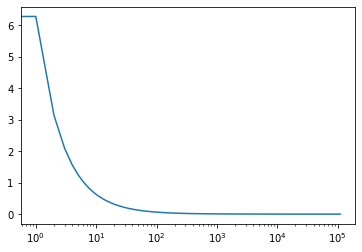

In [6]:
# Settings
fs = 44100.0 # Hz
T = 5.0 # duration (s)
N = int(fs*T) # number of points

# Generate coefficient magnitudes
f_k = np.arange(0, N//2) / (2*math.pi)
C = 1.0 / f_k[1:]
C = np.insert(C, 0, 0.0) # C_0 = 0 => mean = 0

plt.plot(C)
plt.xscale('log')

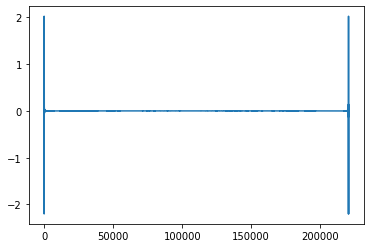

In [7]:
# Generate spectral coefficients with random phase
C_k = np.zeros(N + 1)*1j
for k in range(0, N//2):
    phi_k = np.random.random()*2*math.pi
    C_k[k] = C[k]*np.exp(phi_k*1j)
    C_k[-k] = C[k]*np.exp(-phi_k*1j)
    
plt.plot(C_k.real);

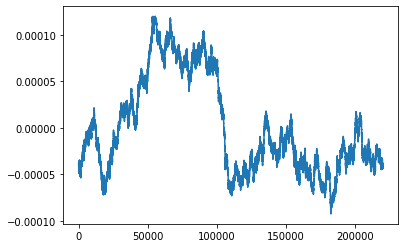

In [8]:
# Generate signal from iFFT
y = np.fft.ifft(C_k)

plt.plot(y.real);

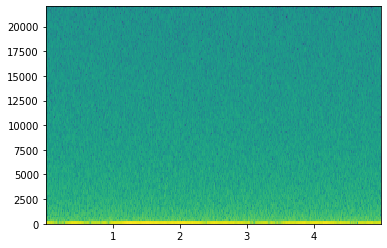

In [9]:
plt.specgram(y.real, Fs=int(fs));

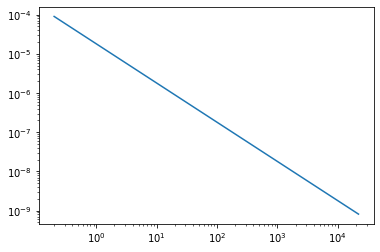

In [11]:
freq, Pxx = signal.periodogram(y.real, fs=fs)
plt.loglog(freq[1:-1], np.sqrt(Pxx[1:-1]));

### Filtering white noise
By creating a filter that decays as approximately $1/f$, pink noise can be estimated by applying such a filter to white noise. However, the result will only be an approximation because, according to [this answer](https://dsp.stackexchange.com/a/376):

>There is no exact (rational, finite-order) filter which can produce pink noise from white noise. This is because the ideal amplitude response of the filter must be proportional to the irrational function $\frac{1}{\sqrt f}$, where $f$ denotes frequency in Hz. However, it is easy enough to generate pink noise to any desired degree of approximation, including perceptually exact.

An example filter given by [Spectral Audio Signal Processing](https://ccrma.stanford.edu/~jos/sasp/sasp.html) is the following transfer function:

$
H(z) = \dfrac{\sum_i B_i z^{-i}}{\sum_j A_j z^{-j}}
$

where:

```
B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
A = [1, -2.494956002, 2.017265875, -0.522189400]
```

In zero-pole format:

$
H(z) = \dfrac{\prod_i \left ( 1 - q_i z^{-1} \right )}{\prod_j \left ( 1 - p_j z^{-1} \right )}
$

other parameters to try include:

```
p = [0.99572754, 0.94790649, 0.53567505]
q = [0.98443604, 0.83392334, 0.07568359]
```

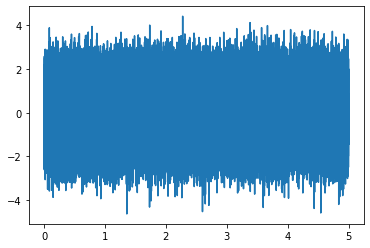

In [12]:
# Generate white noise
T = 5.0 # duration (s)
N = int(T*fs)
mean = 0
std = 1
w = np.random.normal(mean, std, size=N)
t = np.arange(N) / fs

plt.plot(t, w);

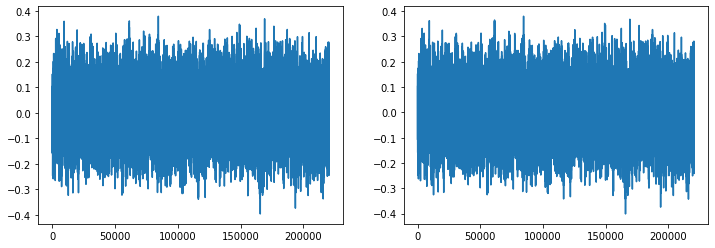

In [13]:
# Apply "pink" filters
# Filter 1
b = np.array([0.049922035, -0.095993537, 0.050612699, -0.004408786])
a = np.array([1, -2.494956002, 2.017265875, -0.522189400])
y_1 = signal.lfilter(b, a, w)

# Filter 2
k = 0.05 # empirical to match filter 1
p = np.array([0.99572754, 0.94790649, 0.53567505])
q = np.array([0.98443604, 0.83392334, 0.07568359])
b, a = signal.zpk2tf(q, p, k)
y_2 = signal.lfilter(b, a, w)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(y_1)
ax[1].plot(y_2);

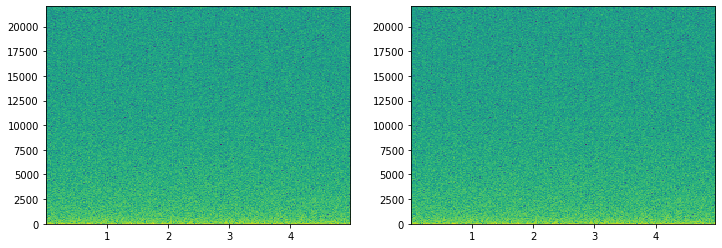

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].specgram(y_1, Fs=int(fs), NFFT=1024)
ax[1].specgram(y_2, Fs=int(fs), NFFT=1024);

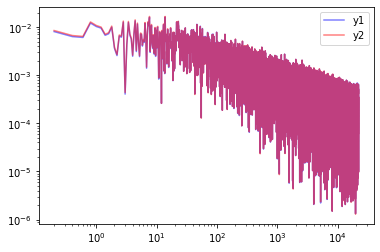

In [15]:
fig, ax = plt.subplots()
freq_1, Pxx_1 = signal.periodogram(y_1, fs=fs)
freq_2, Pxx_2 = signal.periodogram(y_2, fs=fs)
ax.loglog(freq_1[1:-1], np.sqrt(Pxx_1[1:-1]), color='blue',
          alpha=0.5, linestyle='-', label='y1')
ax.loglog(freq_2[1:-1], np.sqrt(Pxx_2[1:-1]), color='red',
          alpha=0.5, linestyle='-', label='y2')
ax.legend(loc=1);

### Voss-McCartney algorithm
The Voss-McCartney algorithm, first published in *Scientific American* by Martin Gardner in 1978 and later improved by McCartney, faithfully produces pink noise by using multiple random number generators as white noise sources. The algorithm is as follows:

1. Create $B \in \mathbb{R}^{N \times (W+1)}$, where $N$ represents the number of time points, and $W$ the number of logarithmically-spaced frequencies (i.e. octaves). Fill the first column ($t_0$) and first row ($f_0$) with random numbers $a_i \in U[0, 1)$. Fill the remaining elements with NaN.
2. Iteratively update each white noise source in octave time intervals. In theory, this results in $N$ updates for the first column, $\frac{N}{2}$ updates for the second column, $\frac{N}{4}$ updates for the third column, and so forth, leading to $\sum_{w=0}^{W} 2^{-w}N \approx 2N$ updates in total. Since $N$ samples were distributed to the first column ($f_0$), the remaining $N$ updates are distributed geometrically across columns (white noise sources). Generate a sample set $\{S_f\}$ consisting of $N$ samples from a geometric distribution with $p=0.5$.
3. Place each update from white noise sources at time points uniformly distributed across the sequence by generating another sample set $\{S_t\}$ consisting of $N$ samples from a uniform distribution $U[0, N)$ without replacement.
4. For each $(s_t, s_f) \in \{S_t, S_f\}$, set $B_{s_t, s_f} \in U[0, 1)$. This represents a change in the value of white noise source for that column. Fill the remaining NaN values top-down.
5. Create the total noise $y \in \mathbb{R}^N$ such that $y_n = \sum_w B_{n, w}$.

Sources:
- ThinkDSP: [article](https://www.dsprelated.com/showarticle/908.php) and [iPython notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)
- music-DSP: [article](http://www.firstpr.com.au/dsp/pink-noise/)

In [16]:
# Settings
N = int(fs)
W = 16
A = np.full((N, W+1), np.nan)

# Fill first row and column
A[0, :] = np.random.random(size=W+1)
A[:, 0] = np.random.random(size=N)

# Generate samples from respective distributions
S_f = np.random.geometric(p=0.5, size=N)
S_f[S_f > W] = 0 # wrap to first column
S_t = np.arange(N)
np.random.shuffle(S_t)

# Add octave-spaced changes to white noise source
A[S_t, S_f] = np.random.random(size=N)

# Fill NaNs top-down (i.e. propagate changes in white noise source)
# Method 1: for-loop iteration over columns
#idx_nan = np.argwhere(np.isnan(A.T)) # (column, row)
#idx_num = np.argwhere(~np.isnan(A.T)) # (column, row)
#for w in np.unique(idx_nan[:, 0]):
#    idx_nan_w = idx_nan[idx_nan[:, 0] == w, 1] # idx of NaNs in column n
#    idx_num_w = idx_num[idx_num[:, 0] == w, 1] # idx of numbers in column n
#    idx_diff = np.argwhere(idx_nan_w[:, np.newaxis] - idx_num_w[np.newaxis, :] > 0)
#    _, counts = np.unique(idx_diff[:, 0], return_counts=True)
#    idx_last = idx_diff[np.cumsum(counts) - 1, 1] # idx of closest number to NaN from top
#    A[idx_nan_w, w] = A[idx_num_w[idx_last], w] # replace NaNs
    
# Method 2: accumulation of indices
idx = np.where(~np.isnan(A), np.arange(N)[:, np.newaxis], 0) # replace NaN with row index
np.maximum.accumulate(idx, axis=0, out=idx) # propagate row indices of NaNs down columns
A = A[idx.reshape([-1], order='F'), np.arange(W+1).repeat(N)].reshape([N, W+1], order='F') # replace NaNs

# Sum across columns (i.e. sum white noise sources)
y = np.sum(A, axis=1)

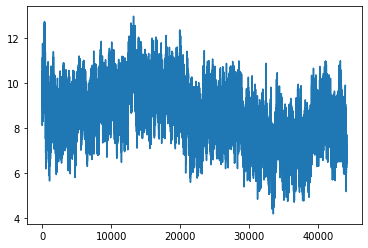

In [17]:
plt.plot(y);

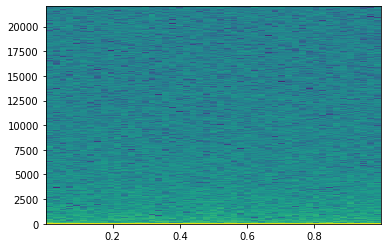

In [18]:
plt.specgram(y, Fs=int(fs), NFFT=1024);

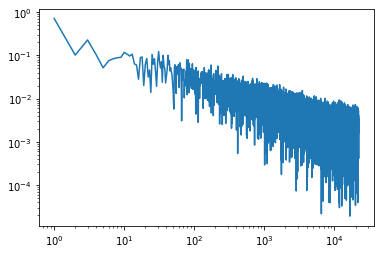

In [19]:
freq, Pxx = signal.periodogram(y, fs=fs)
plt.loglog(freq[1:-1], np.sqrt(Pxx[1:-1]));

### Generate audio file

In [20]:
def pink_noise(fs, T, A, method='voss', **kwargs):
    # Determine number of points
    N = int(fs*T) # number of points
    
    # Use specified method
    if method.lower() == 'voss':
        return _voss(N, A, **kwargs)
    elif method.lower() == 'ifft':
        return _ifft_pn(N, A, **kwargs)
    else:
        raise ValueError('Unknown method %s' % method)

def _voss(N, A, num_sources=16):
    W = num_sources
    B = np.full((N, W+1), np.nan)

    # Fill first row and column
    B[0, :] = np.random.random(size=W+1)
    B[:, 0] = np.random.random(size=N)

    # Generate sampling sets
    S_f = np.random.geometric(p=0.5, size=N)
    S_f[S_f > W] = 0 # wrap to first column
    S_t = np.arange(N)
    np.random.shuffle(S_t)

    # Add octave-spaced changes to white noise source
    B[S_t, S_f] = np.random.random(size=N)

    # Fill NaNs top-down (i.e. propagate changes in white noise source)
    idx = np.where(~np.isnan(B), np.arange(N)[:, np.newaxis], 0) # replace NaN with row index
    np.maximum.accumulate(idx, axis=0, out=idx) # propagate row indices of NaNs down columns
    B = B[idx.reshape([-1], order='F'), np.arange(W+1).repeat(N)].reshape([N, W+1], order='F') # replace NaNs

    # Sum across columns (i.e. sum white noise sources)
    y = np.sum(B, axis=1)

    # Normalize
    return y * (A/np.max(y))

def _ifft_pn(N, A):
    # Determine wave numbers
    f_k = np.arange(0, N//2) / (2*math.pi) # frequencies
    
    # Set magnitudes of spectral coefficients
    C = 1.0 / f_k[1:] # 1/f => pink noise
    C = np.insert(C, 0, 0.0) # C_0 = 0 => mean = 0
    
    # Create spectral coefficients
    C_k = np.zeros(N + 1)*1j # create complex array
    for k in range(0, N//2):
        phi_k = np.random.random()*2*math.pi # random phase
        C_k[k] = C[k]*np.exp(phi_k*1j) 
        C_k[-k] = C[k]*np.exp(-phi_k*1j) # symmetry for real-valued noise
        
    # Inverse FFT
    y = np.fft.ifft(C_k).real
    
    # Normalize
    return y * (A/np.max(y))

In [23]:
filename = 'pink_noise.wav'

# Audio settings
fs = 44100.0 # Hz
T = 5.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 0.25*A_max

with wave.open(output_dir + filename,'wb') as wf:
    # File settings
    wf.setnchannels(1) # mono
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)

    # Create sound
    y = pink_noise(fs=fs, T=T, A=A, method='voss', num_sources=16).astype(np.int16)
    
    # Write frames to file object
    for i in range(len(y)):
        s = struct.pack('<h', y[i])
        wf.writeframesraw(s)

In [24]:
# Check file header
with wave.open(output_dir + filename, 'rb') as wf:
    print('Number of channels: %d' % wf.getnchannels())
    print('')
    T_actual = wf.getnframes() / wf.getframerate()

Number of channels: 1



In [25]:
# Play audio
print('Playing file %s (%.2f seconds)' % (filename, T_actual))
os.system('aplay %s' % (output_dir + filename))
print('done.')

Playing file pink_noise.wav (5.00 seconds)
done.


In [ ]:
# TODO: continuously write pink noise file in Voss method 
# by initializing first row of next chunk to be last row of previous chunk

## Tone cloud
It's difficult to find references, especially with actual code (or anything more than a simple figure). I'll probably go through the labview code in order to see how the McGinley lab does it.

### Naive (no border correction)
Without gating at bin edges, large artifacts appear at discontinuities between chords.

In [26]:
def sample_octaves(f_low, f_high, size=1):
    return np.exp(np.log(f_low) + (np.log(f_high) - np.log(f_low))*np.random.random(size=size))

In [38]:
# Settings
fs = 44100.0 # Hz
T = 5.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 0.25*A_max # sample amplitude
num_tones = 5 # number of tones in chord
f_low = 500 # low frequency (Hz)
f_high = 20000 # high frequency (Hz)
t_chord = 0.100 # chord duration (Hz)

# Determine sample numbers
N = int(fs*T)
num_chords = int(T/t_chord)
n_chord = int(t_chord*fs)

# Generate chords
y = np.zeros(N)
t = np.arange(n_chord) / fs
for i in range(num_chords):
    f_c = sample_octaves(f_low, f_high, size=num_tones) # get frequencies of tones
    y_c = np.sin(2*math.pi*f_c[:, np.newaxis]*t[np.newaxis, :]) # create chord
    y[i*n_chord:(i+1)*n_chord] = np.sum(y_c, axis=0) # add to sequence

# Normalize and convert data type
y = (y*(A/np.max(y))).astype(np.int16) # normalize

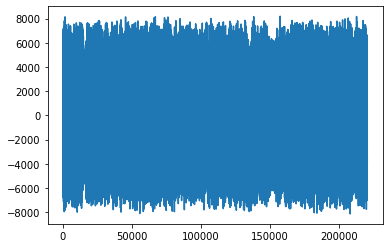

In [39]:
plt.plot(y)

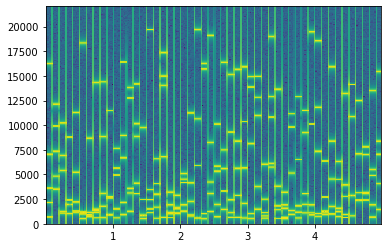

In [40]:
plt.specgram(y, Fs=int(fs), NFFT=1024);

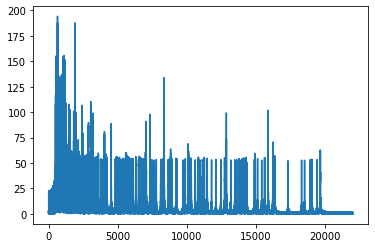

In [41]:
freq, Pxx = signal.periodogram(y, fs=fs)
plt.plot(freq[1:-1], np.sqrt(Pxx[1:-1]));

### Border correction


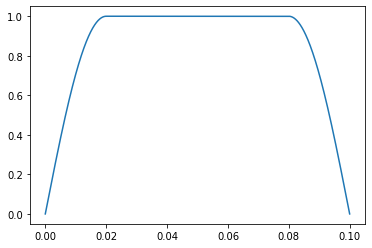

In [42]:
# Create gate
t_gate = 0.020 # seconds
f_gate = 1.0/(4*t_gate) # t_gate = 0.25*period
gate = np.ones(len(t))
idx = int(t_gate*fs) # last/first index of ramping
gate[:idx] = np.sin(2*math.pi*f_gate*t[:idx])
gate[-idx:] = gate[:idx][::-1]

plt.plot(t, gate);

In [43]:
# Settings
fs = 44100.0 # Hz
T = 5.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 0.25*A_max # sample amplitude
num_tones = 5 # number of tones in chord
f_low = 500 # low frequency (Hz)
f_high = 20000 # high frequency (Hz)
t_chord = 0.100 # chord duration (Hz)

# Determine sample numbers
N = int(fs*T)
num_chords = int(T/t_chord)
n_chord = int(t_chord*fs)

# Generate chords
y = np.zeros(N)
t = np.arange(n_chord) / fs
for i in range(num_chords):
    f_c = sample_octaves(f_low, f_high, size=num_tones) # get frequencies of tones
    y_c = np.sin(2*math.pi*f_c[:, np.newaxis]*t[np.newaxis, :]) # create chord
    y[i*n_chord:(i+1)*n_chord] = gate*np.sum(y_c, axis=0) # add to sequence

# Normalize and convert data type
y = (y*(A/np.max(y))).astype(np.int16) # normalize

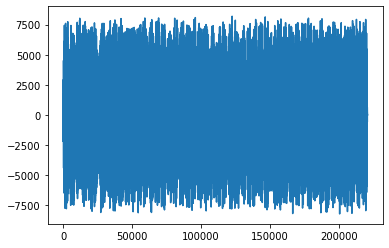

In [46]:
plt.plot(y);

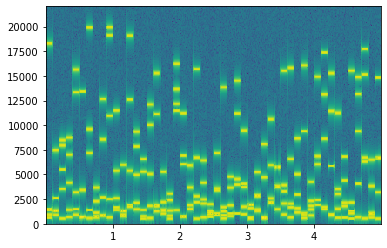

In [47]:
plt.specgram(y.real, Fs=int(fs), NFFT=512);

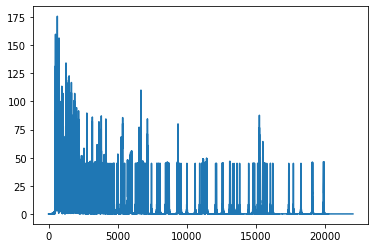

In [48]:
freq, Pxx = signal.periodogram(y.real, fs=fs)
plt.plot(freq[1:-1], np.sqrt(Pxx[1:-1]));

### Generate audio

In [49]:
def tone_cloud(fs, T, A, 
               num_tones=5,
               f_low=1000,
               f_high=20000,
               t_chord=0.200,
               t_gate=0.020):
    # Determine number of samples
    N = int(fs*T)
    num_chords = int(T/t_chord)
    n_chord = int(t_chord*fs)
    t = np.arange(n_chord)/fs
    
    # Create sine gate at borders
    gate = np.ones(len(t))
    if t_gate > 0.0:
        f_gate = 1.0/(4*t_gate)

        idx = int(t_gate*fs)
        gate[:idx] = np.sin(2*math.pi*f_gate*t[:idx])
        gate[-idx:] = gate[:idx][::-1]

    # Create chords (can run continuously if needed)
    y = np.zeros(N)
    for i in range(num_chords):
        f_c = sample_octaves(f_low, f_high, size=num_tones)
        y_c = np.sin(2*math.pi*f_c[:, np.newaxis]*t[np.newaxis, :])
        y[i*n_chord:(i+1)*n_chord] = gate*np.sum(y_c, axis=0)

    # Normalize
    return y*(A/np.max(y))

In [54]:
filename = 'tone_cloud_gating.wav'

# Audio settings
fs = 44100.0 # Hz
T = 5.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 0.25*A_max # sample amplitude
num_tones # number of tones in chord
f_low = 500 # low frequency (Hz)
f_high = 10000 # high frequency (Hz)
t_chord = 0.030 # chord duration (Hz)
t_gate = 0.005 # gate duration (s)

with wave.open(output_dir + filename,'wb') as wf:
    # File settings
    wf.setnchannels(1) # mono
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)

    # Create sound
    y = tone_cloud(fs=fs, 
                   T=T, 
                   A=A,
                   num_tones=num_tones,
                   f_low=f_low,
                   f_high=f_high,
                   t_chord=t_chord,
                   t_gate=t_gate)
    y = y.astype(np.int16)
    
    # Write frames to file object
    for i in range(len(y)):
        s = struct.pack('<h', y[i])
        wf.writeframesraw(s)

In [52]:
# Check file header
with wave.open(output_dir + filename, 'rb') as wf:
    print('Number of channels: %d' % wf.getnchannels())
    print('')
    T_actual = wf.getnframes() / wf.getframerate()

Number of channels: 1



In [53]:
# Play audio
print('Playing file %s (%.2f seconds)' % (filename, T_actual))
os.system('aplay %s' % (output_dir + filename))
print('done.')

Playing file tone_cloud_no_gating.wav (5.00 seconds)
done.
